In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import dask.dataframe as dd
from catboost import CatBoostRegressor, Pool
import os
import seaborn as sns
import matplotlib.pylab as plt
from pandas.plotting import autocorrelation_plot

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
pd.options.display.max_columns = 999

## Data load

In [4]:
calendar_df = pd.read_csv("data/calendar.csv", low_memory=False)
sales_df = pd.read_csv("data/sales_train_validation.csv", low_memory=False)
prices_df = pd.read_csv("data/sell_prices.csv", low_memory=False)

In [5]:
sample_submission = pd.read_csv("data/sample_submission.csv", low_memory=False)

In [6]:
sales_denorm_df = (
    sales_df
#     .sample(frac=0.1)
    .melt(
        id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name="d",
        value_name="sales"
    )
    .merge(calendar_df, on=["d"])
    .merge(prices_df, on=["store_id", "item_id", "wm_yr_wk"])
    .assign(total_sales=lambda x: x["sales"] * x["sell_price"])
    .assign(day=lambda x: x["d"].str.slice(start=2).astype(int))
    .assign(date=lambda x: dd.to_datetime(x["date"]))
    .assign(dayofyear=lambda x: x["date"].dt.dayofyear)
    .assign(dayofmonth=lambda x: x["date"].dt.day)
    .drop(columns=["d"])
    .sort_values(by=["id", "date"], ascending=True)
    .assign(sales_lag28=lambda x: x.groupby(["id"])["sales"].shift(28).values)
    .assign(sales_lag28_win7=lambda x: x.groupby(["id"])["sales_lag28"].rolling(7).mean().values)
    .assign(sales_lag28_win30=lambda x: x.groupby(["id"])["sales_lag28"].rolling(30).mean().values)
    .assign(sales_lag28_win121=lambda x: x.groupby(["id"])["sales_lag28"].rolling(121).mean().values)
    .assign(sales_lag28_win365=lambda x: x.groupby(["id"])["sales_lag28"].rolling(365).mean().values)
)

In [8]:
sales_denorm_df.to_parquet("data/sales_denorm_df.parquet")

In [9]:
sales_denorm_df = pd.read_parquet("data/sales_denorm_df.parquet")

In [7]:
sales_denorm_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,total_sales,day,dayofyear,dayofmonth,sales_lag28,sales_lag28_win7,sales_lag28_win30,sales_lag28_win121,sales_lag28_win365
4032,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.0,6.0,1,29,29,NaN,NaN,NaN,NaN,NaN
4033,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.0,0.0,2,30,30,NaN,NaN,NaN,NaN,NaN
4034,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,2.0,0.0,3,31,31,NaN,NaN,NaN,NaN,NaN
4035,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,2.0,2.0,4,32,1,NaN,NaN,NaN,NaN,NaN
4036,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,2.0,8.0,5,33,2,NaN,NaN,NaN,NaN,NaN


## Data exploration
- are there missing rows in the time series from when the product was not sold?
- are there missing or zero-valued prices?
- is the data zero-inflated?
- how to incorporate events?
- how to incorporate time series trends?

In [10]:
sales_denorm_df.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,sales,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,total_sales,day,dayofyear,dayofmonth,sales_lag28,sales_lag28_win7,sales_lag28_win30,sales_lag28_win121,sales_lag28_win365
count,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.602796e+07,4.517424e+07,4.499130e+07,4.429003e+07,4.151671e+07,3.411992e+07
mean,1.427294e+00,1.137348e+04,3.996688e+00,6.398704e+00,2.013552e+03,3.283675e-01,3.287932e-01,3.288327e-01,4.408089e+00,4.077447e+00,1.083652e+03,1.793004e+02,1.571699e+01,1.428066e+00,1.428274e+00,1.427763e+00,1.429328e+00,1.443713e+00
std,4.310440e+00,1.437756e+02,2.000825e+00,3.480230e+00,1.470835e+00,4.696193e-01,4.697747e-01,4.697891e-01,3.403657e+00,1.066385e+01,5.262105e+02,1.063547e+02,8.785454e+00,4.322845e+00,3.767826e+00,3.599466e+00,3.478459e+00,3.417663e+00
min,0.000000e+00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,0.000000e+00,1.110600e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e-01,0.000000e+00,3.800000e+01,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,1.114400e+04,1.000000e+00,2.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.240000e+00,0.000000e+00,3.070000e+02,3.600000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.438017e-02,1.068493e-01
25%,0.000000e+00,1.124300e+04,2.000000e+00,3.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.180000e+00,0.000000e+00,6.650000e+02,8.500000e+01,8.000000e+00,0.000000e+00,1.428571e-01,1.666667e-01,2.066116e-01,2.383562e-01
50%,0.000000e+00,1.140600e+04,4.000000e+00,6.000000e+00,2.014000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.470000e+00,0.000000e+00,1.137000e+03,1.770000e+02,1.600000e+01,0.000000e+00,4.285714e-01,5.333333e-01,5.537190e-01,5.808219e-01
75%,1.000000e+00,1.151100e+04,6.000000e+00,9.000000e+00,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.840000e+00,4.780000e+00,1.535000e+03,2.720000e+02,2.300000e+01,1.000000e+00,1.428571e+00,1.366667e+00,1.363636e+00,1.369863e+00
90%,4.000000e+00,1.154300e+04,7.000000e+00,1.100000e+01,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,8.640000e+00,1.178000e+01,1.762000e+03,3.290000e+02,2.800000e+01,4.000000e+00,3.285714e+00,3.166667e+00,3.140496e+00,3.139726e+00


In [11]:
sales_denorm_df.select_dtypes(exclude=["number"]).describe()

,id,item_id,dept_id,cat_id,store_id,state_id,date,weekday,event_name_1,event_type_1,event_name_2,event_type_2
count,46027957,46027957,46027957,46027957,46027957,46027957,46027957,46027957,3686390,3686390,94483,94483
unique,30490,3049,7,3,10,3,1913,7,30,4,4,2
top,HOUSEHOLD_2_136_WI_2_validation,FOODS_3_227,FOODS_3,FOODS,TX_2,CA,2016-04-04 00:00:00,Saturday,StPatricksDay,National,Father's day,Cultural
freq,1913,19130,12344860,21395953,4722509,18217798,30490,6597201,142824,1241227,28295,66784
first,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-24 00:00:00,NaN,NaN,NaN,NaN,NaN


## Model build

In [12]:
train_df, val_df = train_test_split(sales_denorm_df, train_size=0.8)
val_df, test_df = train_test_split(val_df, train_size=0.5)

In [13]:
lag = 28
features = (
    ["dayofyear", "year", "month", "dayofmonth", "wday", "dept_id", "item_id", "store_id", "sell_price", f"sales_lag{lag}"]
    + [f"sales_lag{lag}_win{window}" for window in (30, 121, 365)]
)

In [14]:
complete_pool = Pool(
    data=sales_denorm_df[features], 
    label=sales_denorm_df["sales"],
    weight=sales_denorm_df["sell_price"],
    cat_features=["dept_id", "store_id", "item_id"],
)

In [15]:
train_pool = Pool(
    data=train_df[features], 
    label=train_df["sales"],
    weight=train_df["sell_price"],
    cat_features=["dept_id", "store_id", "item_id"],
)

In [16]:
eval_pool = Pool(
    data=val_df[features], 
    label=val_df["sales"],
    weight=val_df["sell_price"],
    cat_features=["dept_id", "store_id", "item_id"],
)

In [17]:
test_pool = Pool(
    data=test_df[features],
    label=test_df["sales"],
    weight=test_df["sell_price"],
    cat_features=["dept_id", "store_id", "item_id"],
)

In [67]:
model = CatBoostRegressor(
    iterations=1000,
#     rsm=0.1,
    boosting_type="Plain",
)

In [68]:
# model.load_model("data/model_200511010119.cbm")

In [ ]:
model.fit(
    train_pool,
    eval_set=eval_pool,
    use_best_model=True,
    plot=True,
#     early_stopping_rounds=50,
    metric_period=10,
)

current_time = datetime.now().strftime('%y%m%d%H%M%S')
model.save_model("data/model.cbm", pool=train_pool)
model.save_model(f"data/model_{current_time}.cbm", pool=train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.336111
0:	learn: 2.3843821	test: 2.3873553	best: 2.3873553 (0)	total: 4.86s	remaining: 1h 20m 59s
10:	learn: 1.8280486	test: 1.8277246	best: 1.8277246 (10)	total: 51.8s	remaining: 1h 17m 34s
20:	learn: 1.7961937	test: 1.7965858	best: 1.7965858 (20)	total: 1m 38s	remaining: 1h 16m 37s
30:	learn: 1.7812209	test: 1.7837249	best: 1.7837249 (30)	total: 2m 28s	remaining: 1h 17m 24s
40:	learn: 1.7691955	test: 1.7716138	best: 1.7716138 (40)	total: 3m 18s	remaining: 1h 17m 33s
50:	learn: 1.7608233	test: 1.7640926	best: 1.7640926 (50)	total: 4m 4s	remaining: 1h 15m 58s
60:	learn: 1.7491959	test: 1.7523288	best: 1.7523288 (60)	total: 4m 58s	remaining: 1h 16m 27s
70:	learn: 1.7418913	test: 1.7465345	best: 1.7465345 (70)	total: 5m 48s	remaining: 1h 15m 57s
80:	learn: 1.7355472	test: 1.7407196	best: 1.7407196 (80)	total: 6m 40s	remaining: 1h 15m 42s
90:	learn: 1.7296212	test: 1.7356099	best: 1.7356099 (90)	total: 7m 31s	remaining: 1h 15m 10s
100:	learn: 1.7228750	test: 1.72843

In [ ]:
print(
    f"Train score: {model.score(train_pool)}, "
    f"Eval score: {model.score(eval_pool)}, "
    f"Test score: {model.score(test_pool)}"
)

## Visualize predictions

In [36]:
sales_denorm_df["prediction"] = model.predict(complete_pool)

sales_denorm_df["total_sales_prediction"] = (
    sales_denorm_df["prediction"] * sales_denorm_df["sell_price"]
)

sales_denorm_df["error"] = (
    sales_denorm_df["total_sales_prediction"] - sales_denorm_df["total_sales"]
)

sales_denorm_df["abs_error"] = abs(
    sales_denorm_df["total_sales_prediction"] - sales_denorm_df["total_sales"]
)

### Actuals

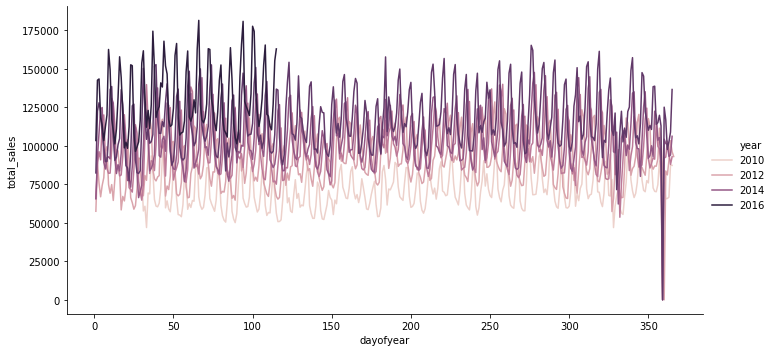

In [37]:
sns.relplot(
    x="dayofyear",
    y="total_sales",
    hue="year",
    data=sales_denorm_df.groupby(["year", "dayofyear"], as_index=False)["total_sales"].sum(),
    kind="line",
    height=5,
    aspect=2,
)

### Prediction

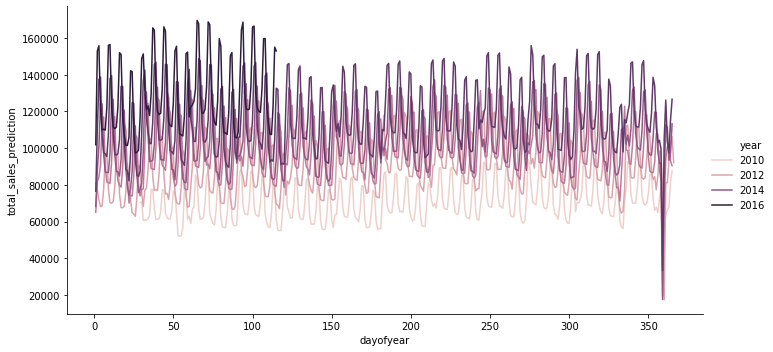

In [38]:
sns.relplot(
    x="dayofyear",
    y="total_sales_prediction",
    hue="year",
    data=sales_denorm_df.groupby(["year", "dayofyear"], as_index=False)["total_sales_prediction"].sum(),
    kind="line",
    height=5,
    aspect=2,
)

### Error

#### Bias

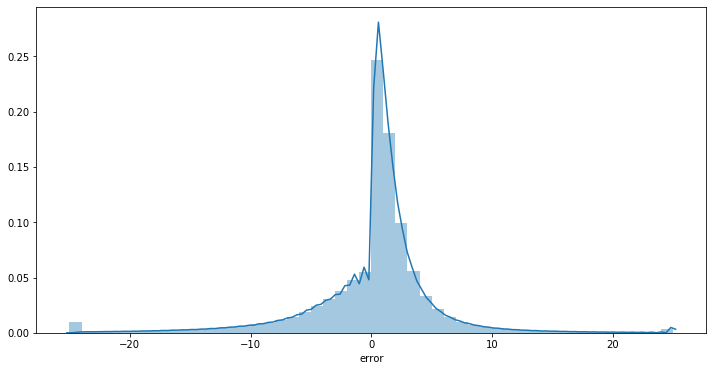

In [39]:
plt.figure(figsize=(12, 6))
sns.distplot(np.minimum(25, np.maximum(-25, sales_denorm_df["error"])))

In [40]:
sales_denorm_df["error"].describe()

count    4.602796e+07
mean    -7.299043e-04
std      7.106909e+00
min     -1.765112e+03
25%     -9.715076e-01
50%      7.982732e-01
75%      2.155038e+00
max      6.420383e+02
Name: error, dtype: float64

#### Error autocorrelation

In [41]:
def autocorr_plot(df):
    plt.figure(figsize=(12, 6))
    ax = plt.gca(ylim=(-0.5, 0.5), xlim=(0, 25))
    autocorrelation_plot(df.groupby(["date"])["error"].mean().sort_index(), ax=ax)
    plt.title(df.cat_id.unique())
    plt.show()

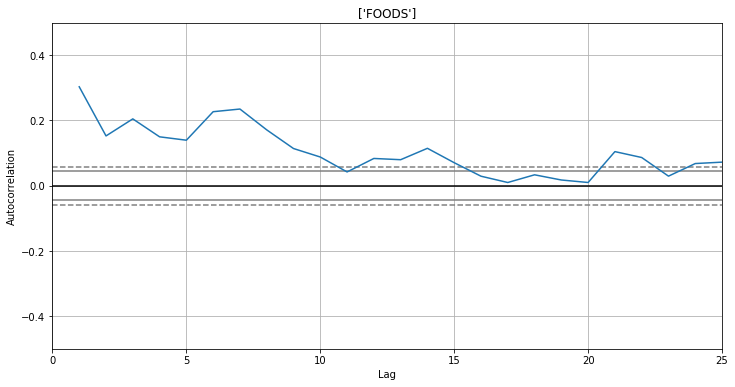

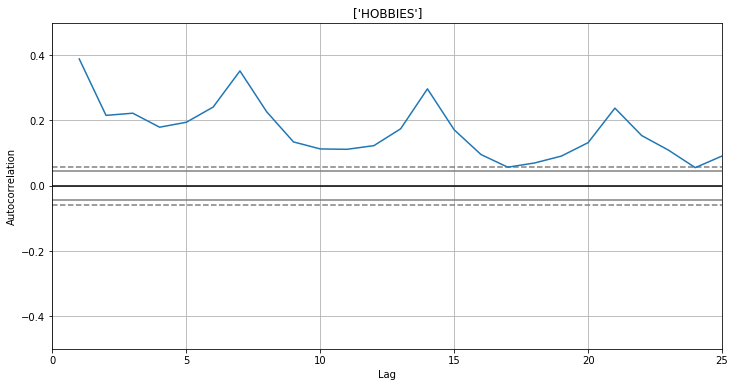

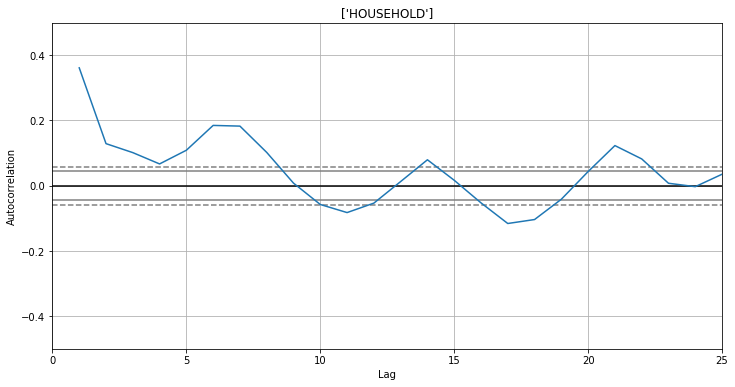

In [42]:
sales_denorm_df.groupby(["cat_id"]).apply(lambda x: autocorr_plot(x));

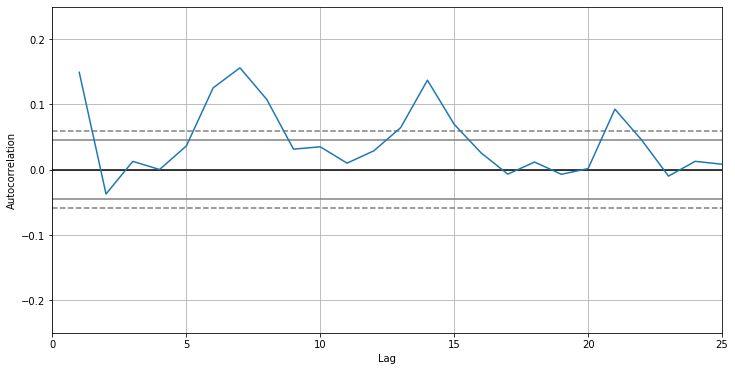

In [43]:
plt.figure(figsize=(12, 6))
autocorrelation_plot(sales_denorm_df.groupby(["date"])["error"].mean().sort_index())
plt.ylim((-0.25,0.25))
plt.xlim((0,25))
plt.show();

#### Error over time

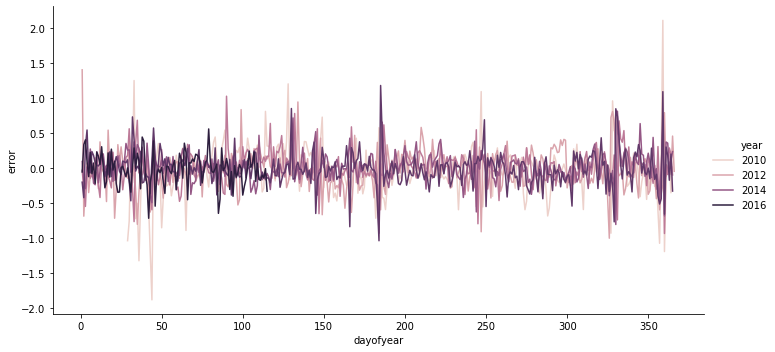

In [44]:
sns.relplot(
    x="dayofyear",
    y="error",
    hue="year",
    data=sales_denorm_df.groupby(["year", "dayofyear"], as_index=False)["error"].mean(),
    kind="line",
    height=5,
    aspect=2,
)

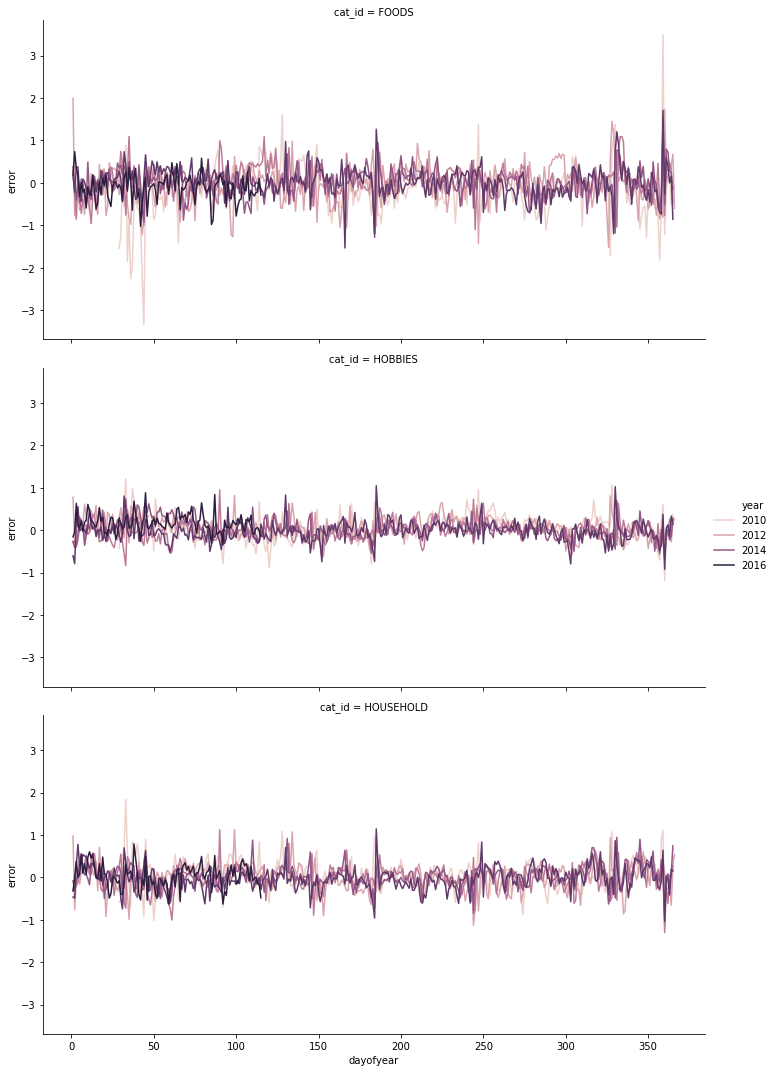

In [45]:
sns.relplot(
    x="dayofyear",
    y="error",
    hue="year",
    row="cat_id",
    data=sales_denorm_df.groupby(["year", "dayofyear", "cat_id"], as_index=False)["error"].mean(),
    kind="line",
    height=5,
    aspect=2,
)

#### Absolute error

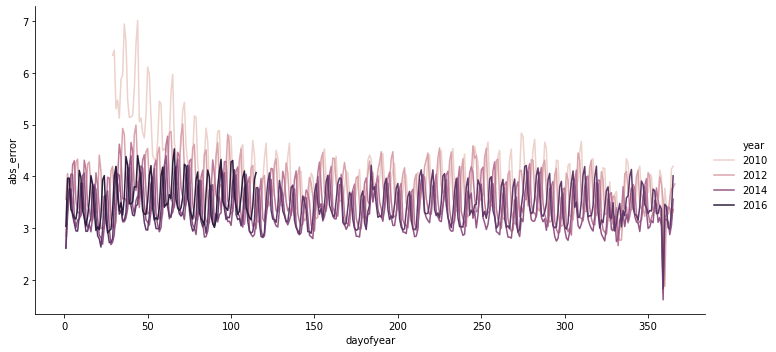

In [46]:
sns.relplot(
    x="dayofyear",
    y="abs_error",
    hue="year",
    data=sales_denorm_df.groupby(["year", "dayofyear"], as_index=False)["abs_error"].mean(),
    kind="line",
    height=5,
    aspect=2,
)

## Forecast

### Construct input df

In [47]:
max_training_date = sales_denorm_df.date.max()

In [48]:
items_df = sales_df[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]].drop_duplicates()

In [49]:
sales_melted_df = (
    sales_df
    .melt(
        id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name="d",
        value_name="sales"
    )
)

In [50]:
input_df = (
    items_df.assign(key=0)
    .merge(calendar_df.assign(key=0))
    .merge(prices_df, on=["store_id", "item_id", "wm_yr_wk"])
    .merge(sales_melted_df[["item_id", "store_id", "d", "sales"]], on=["item_id", "store_id", "d"], how="left")
    .assign(day=lambda x: x["d"].str.slice(start=2).astype(int))
    .assign(date=lambda x: dd.to_datetime(x["date"]))
    .assign(dayofyear=lambda x: x["date"].dt.dayofyear)
    .assign(dayofmonth=lambda x: x["date"].dt.day)
    .sort_values(by=["id", "date"], ascending=True)
    .assign(sales_lag28=lambda x: x.groupby(["id"])["sales"].shift(28).values)
    .assign(sales_lag28_win7=lambda x: x.groupby(["id"])["sales_lag28"].rolling(7).mean().values)
    .assign(sales_lag28_win30=lambda x: x.groupby(["id"])["sales_lag28"].rolling(30).mean().values)
    .assign(sales_lag28_win121=lambda x: x.groupby(["id"])["sales_lag28"].rolling(121).mean().values)
    .assign(sales_lag28_win365=lambda x: x.groupby(["id"])["sales_lag28"].rolling(365).mean().values)
    .drop(columns=["d", "key", "sales"])
)

In [51]:
input_df.to_parquet("data/input_df.parquet")

In [52]:
input_df = pd.read_parquet("data/input_df.parquet")

In [53]:
input_df["is_forecasted"] = input_df["date"].gt(max_training_date)

In [54]:
input_df["days_ahead"] = (input_df["date"] - max_training_date).dt.days

In [55]:
input_df["submission_days_ahead"] = np.minimum(input_df["days_ahead"], (input_df["days_ahead"] - 1) % 28 + 1)

In [56]:
input_df["type"] = (
    np.where(input_df["days_ahead"].ge(29), "evaluation", "validation")
)

In [57]:
len(input_df.date.unique()), len(input_df.item_id.unique())

(1969, 3049)

In [58]:
sales_denorm_df.shape

(46027957, 34)

In [59]:
input_df.shape

(47735397, 32)

### Score inputs

In [60]:
forecast_pool = Pool(
    data=input_df[features], 
    cat_features=["dept_id", "store_id", "item_id"],
)

In [61]:
input_df["prediction"] = model.predict(forecast_pool)

input_df["total_sales_prediction"] = (
    input_df["prediction"] * input_df["sell_price"]
)

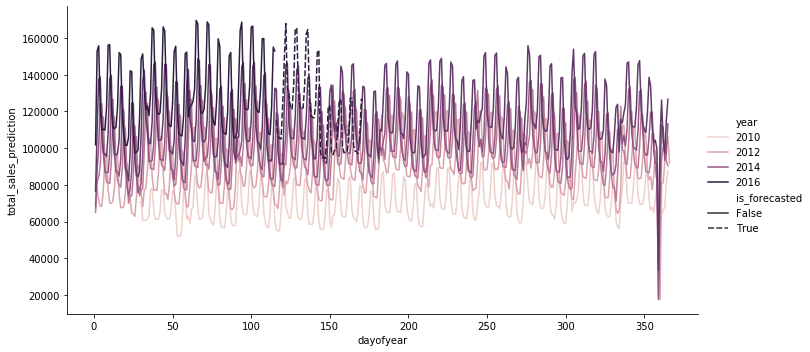

In [62]:
sns.relplot(
    x="dayofyear",
    y="total_sales_prediction",
    hue="year",
    style="is_forecasted",
    data=input_df.groupby(["year", "dayofyear", "is_forecasted"], as_index=False)["total_sales_prediction"].sum(),
    kind="line",
    height=5,
    aspect=2,
)

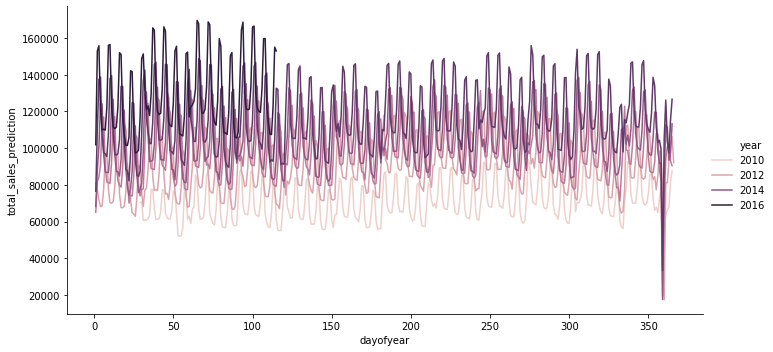

In [63]:
sns.relplot(
    x="dayofyear",
    y="total_sales_prediction",
    hue="year",
    data=sales_denorm_df.groupby(["year", "dayofyear"], as_index=False)["total_sales_prediction"].sum(),
    kind="line",
    height=5,
    aspect=2,
)

### Construct submission dataframe

In [64]:
submission = (
    input_df
    .query("days_ahead > 0")
    .assign(f=lambda x: "F" + x["submission_days_ahead"].astype(str))
    .assign(id=lambda x: x["item_id"] + "_" + x["store_id"] + "_" + x["type"])
    .pivot(index="id", values="prediction", columns="f")[[f"F{i+1}" for i in range(28)]]
    .reset_index()
)

In [65]:
submission.head()

f,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.921719,0.862989,0.865362,0.858900,0.936204,1.083666,1.076314,0.915512,0.868540,0.857948,0.857948,0.959327,1.074073,1.066721,0.907331,0.846011,0.850419,0.850419,0.923746,1.078761,1.071409,0.912018,0.850729,0.850449,0.847206,0.941244,1.093694,1.086342
1,FOODS_1_001_CA_1_validation,0.884420,0.793416,0.793136,0.748662,0.975151,0.894836,0.907130,1.041880,0.875072,1.078321,0.960923,1.073738,1.309674,1.504847,1.136425,0.961203,1.000410,1.000410,1.037043,1.515021,1.305144,1.138164,0.988990,0.988710,0.949224,0.910976,1.319810,0.933008
2,FOODS_1_001_CA_2_evaluation,0.923463,0.864733,0.867106,0.860645,0.937948,1.105707,1.098356,0.917256,0.870285,0.859692,0.859692,0.961072,1.096114,1.088763,0.909075,0.847755,0.852163,0.852163,0.925491,1.100802,1.093450,0.913763,0.852473,0.852193,0.848950,0.942988,1.115735,1.108383
3,FOODS_1_001_CA_2_validation,0.871640,0.792144,0.791864,0.786876,0.801904,0.870731,0.947903,0.790537,0.741581,0.745872,0.651699,0.725026,0.816758,0.809406,0.728986,0.651979,0.720457,0.513222,0.638676,0.665416,2.026992,0.931937,0.881626,0.881347,1.057128,0.864747,0.953914,1.274710
4,FOODS_1_001_CA_3_evaluation,1.449851,1.391121,1.377273,1.370812,1.420356,1.552333,1.584037,1.443644,1.396672,1.380442,1.380442,1.454062,1.546568,1.578271,1.439291,1.377971,1.366159,1.366159,1.411726,1.551255,1.582959,1.443978,1.382688,1.366189,1.362945,1.429223,1.566189,1.597892


In [66]:
current_time = datetime.now().strftime('%y%m%d%H%M%S')
submission.to_csv("data/submission.csv", index=False)
submission.to_csv(f"data/submission_{current_time}", index=False)